# Fitting experimental data to thermodynamic models

Besides calculating and visualizing phase equilibria using known models, **pycalphad** also enables you to fit experimental data to a parameterized thermodynamic model. While pycalphad handles construction of the energy functions and equilibrium calculation, a separate module handles the numerical details of fitting disparate sources of data to the thermodynamic functions.

Here we consider the case study of the Al-Zn system. First, we use a TDB file as the setup for our model parameterizations. Note that not all of the parameters have not been filled in. These are what we will fit.

In [1]:
%matplotlib inline

TDB_STR = """
$ Al-Zn
 ELEMENT /-   ELECTRON_GAS              0.0000E+00  0.0000E+00  0.0000E+00!
 ELEMENT VA   VACUUM                    0.0000E+00  0.0000E+00  0.0000E+00!
 ELEMENT AL   FCC_A1                    2.6982E+01  4.5773E+03  2.8322E+01!
 ELEMENT ZN   HCP_ZN                    6.5390E+01  5.6568E+03  4.1631E+01!
 FUNCTION  GHSERAL  298.0
    -7976.15+137.0715*T-24.36720*T*LN(T)-1.884662E-3*T**2-0.877664E-6*T**3
    +74092*T**(-1);                                                   700.00 Y
    -11276.24+223.0269*T-38.58443*T*LN(T)+18.531982E-3*T**2-5.764227E-6*T**3
    +74092*T**(-1);                                                    933.6 Y
    -11277.68+188.6620*T-31.74819*T*LN(T)-1234.26E25*T**(-9);        2900.00 N ! 
 FUNCTION  GALLIQ   298.0
    +3029.403+125.2307*T-24.36720*T*LN(T)-1.884662E-3*T**2-0.877664E-6*T**3
    +74092*T**(-1)+79.401E-21*T**7;                                   700.00 Y
    -270.6860+211.1861*T-38.58443*T*LN(T)+18.53198E-3*T**2-5.764227E-6*T**3
    +74092*T**(-1)+79.401E-21*T**7;                                    933.6 Y
    -795.7090+177.4100*T-31.74819*T*LN(T);                           2900.00 N !
 FUNCTION  GALHCP   298.0  +5481-1.8*T+GHSERAL#;                      6000  N !
 FUNCTION GHSERZN    298.0  -7285.787+118.4693*T-23.70131*T*LN(T)
     -.001712034*T**2-1.264963E-06*T**3;                              692.7 Y
     -11070.60+172.3449*T-31.38*T*LN(T)+4.70657E+26*T**(-9);           1700 N !
 FUNCTION GZNLIQ     298.0  -1.285170+108.1769*T-23.70131*T*LN(T)
     -.001712034*T**2-1.264963E-06*T**3-3.585652E-19*T**7;            692.7 Y
     -11070.60+172.3449*T-31.38*T*LN(T)+4.70657E+26*T**(-9);           1700 N !
 FUNCTION GZNLIQ     298.14  +7157.213-10.29299*T-3.5896E-19*T**7+GHSERZN#;
                                                                      692.7 Y
     +7450.168-10.737066*T-4.7051E+26*T**(-9)+GHSERZN#;                 1700 N !
 FUNCTION GZNFCC     298.15  +2969.82-1.56968*T+GHSERZN#;               1700 N !
$-------------------------------------------------------------------------------
 TYPE_DEFINITION % SEQ *!
 PHASE LIQUID %  1  1.0  !
 CONSTITUENT LIQUID :AL,ZN :  !
   PARAMETER G(LIQUID,AL;0)      298.15  +GALLIQ#;                      2900 N !
   PARAMETER G(LIQUID,ZN;0)      298.15  +GZNLIQ#;                      1700 N !
   PARAMETER G(LIQUID,AL,ZN;0)   298.15  LIQALZN0H-LIQALZN0S*T;         6000 N !
 PHASE FCC_A1  %  1  1.0  !
 CONSTITUENT FCC_A1  :AL,ZN :  !
   PARAMETER G(FCC_A1,AL;0)      298.15  +GHSERAL#;                     2900 N !
   PARAMETER G(FCC_A1,ZN;0)      298.15  +GZNFCC#;                      1700 N !
   PARAMETER G(FCC_A1,AL,ZN;0)   298.15  FCCALZN0H-FCCALZN0S*T;         6000 N !
   PARAMETER G(FCC_A1,AL,ZN;1)   298.15  FCCALZN1H-FCCALZN1S*T;         6000 N !
   PARAMETER G(FCC_A1,AL,ZN;2)   298.15  FCCALZN2H-FCCALZN2S*T;         6000 N !
 PHASE HCP_A3  %  1  1.0  !
 CONSTITUENT HCP_A3  :AL,ZN :  !
  PARAMETER G(HCP_A3,AL;0)       298.15  +GALHCP#;                      2900 N !
  PARAMETER G(HCP_A3,ZN;0)       298.15  +GHSERZN#;                     1700 N !
  PARAMETER G(HCP_A3,AL,ZN;0)    298.15  HCPALZN0H-HCPALZN0S*T;         6000 N !
  PARAMETER G(HCP_A3,AL,ZN;3)    298.15  HCPALZN3H-HCPALZN3S*T;         6000 N !"""

Now we will import pycalphad and load the database.

In [2]:
from pycalphad import Database, Model, binplot
import pycalphad.variables as v
import matplotlib.pyplot as plt
from sympy import Symbol

# Initialize database and choose active phases
db_alzn = Database(TDB_STR)
my_phases_alzn = ['LIQUID', 'FCC_A1', 'HCP_A3']

## Prior to fitting

First, we'll show what the phase diagram looks like without any binary interaction parameters. In this diagram only the pure component lattice stabilities of each phase relative to their standard states are considered.

CPU times: user 1.46 s, sys: 22 ms, total: 1.49 s
Wall time: 1.49 s


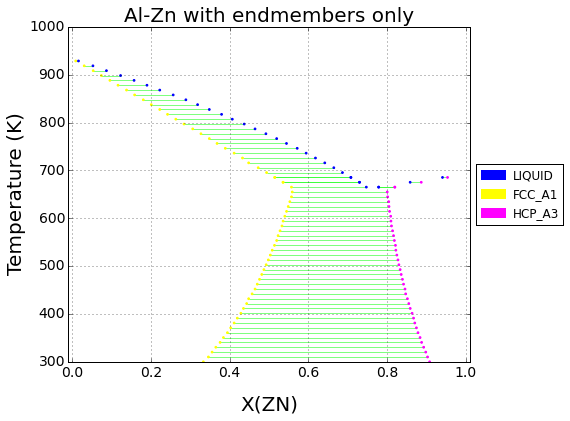

In [3]:
blank_parameters = {
    'LIQALZN0H': 0.0,
    'LIQALZN0S': 0.0,
    'FCCALZN0H': 0.0,
    'FCCALZN0S': 0.0,
    'FCCALZN1H': 0.0,
    'FCCALZN1S': 0.0,
    'FCCALZN2H': 0.0,
    'FCCALZN2S': 0.0,
    'HCPALZN0H': 0.0,
    'HCPALZN0S': 0.0,
    'HCPALZN3H': 0.0,
    'HCPALZN3S': 0.0
    }

models = {
    'LIQUID': Model(db_alzn, ['AL', 'ZN'], 'LIQUID', parameters=blank_parameters),
    'FCC_A1': Model(db_alzn, ['AL', 'ZN', 'VA'], 'FCC_A1', parameters=blank_parameters),
    'HCP_A3': Model(db_alzn, ['AL', 'ZN', 'VA'], 'HCP_A3', parameters=blank_parameters)
    }

fig = plt.figure(figsize=(9,6))
%time ax = binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, 'X(ZN)', 300, 1000, ax=plt.gca(), model=models)
ax = ax.set_title('Al-Zn with endmembers only', fontsize=20)

Now load a test Comma-Separated Values (CSV) file with some phase equilibria data. This data could be from experiment, *ab-initio* methods or another source. Let's plot the data on top of our phase diagram to get an idea of what we're dealing with here.

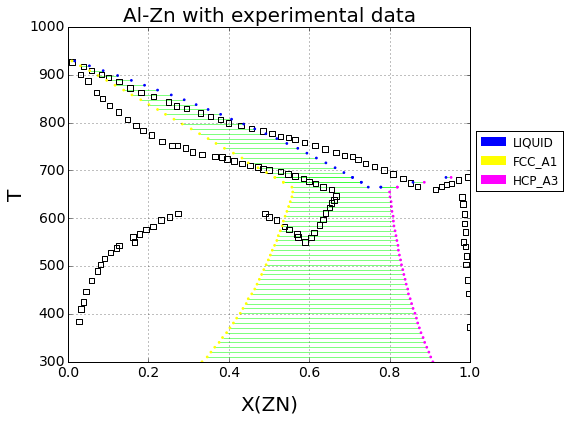

In [10]:
import pandas as pd
from pycalphad.plot.utils import phase_legend

phase_eq = pd.read_csv('alzn_test_phase_eq.csv')

fig = plt.figure(figsize=(9,6))
ax = binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, 'X(ZN)', 300, 1000, ax=plt.gca(), model=models)
ax.set_title('Al-Zn with experimental data', fontsize=20)
legend_handles, colors = phase_legend(my_phases_alzn)
for phase, phase_df in phase_eq.groupby('Phase'):
    ax = phase_df.plot(kind='scatter', x='X(ZN)', y='T', ax=ax, edgecolor='black',
                       s=30, xlim=(0,1), marker='s', facecolor='none')
ax = ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))

## Starting parameter values
Let's imagine we have some way (first-principles calculations, intuition or both) to guess some starting values for our parameters.

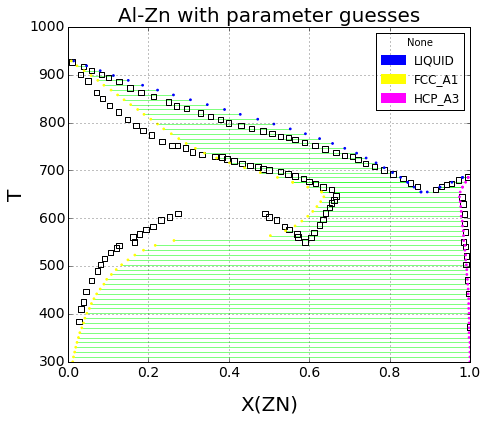

In [11]:
perturbed_parameters = {
    'LIQALZN0H': 10000,
    'LIQALZN0S': 3,
    'FCCALZN0H': 7000,
    'FCCALZN0S': -0.2,
    'FCCALZN1H': 5000,
    'FCCALZN1S': 4,
    'FCCALZN2H': -3000,
    'FCCALZN2S': -3,
    'HCPALZN0H': 17000,
    'HCPALZN0S': 6,
    'HCPALZN3H': -700,
    'HCPALZN3S': 1
    }
fit_models = {
    'LIQUID': Model(db_alzn, ['AL', 'ZN'], 'LIQUID', parameters=perturbed_parameters),
    'FCC_A1': Model(db_alzn, ['AL', 'ZN', 'VA'], 'FCC_A1', parameters=perturbed_parameters),
    'HCP_A3': Model(db_alzn, ['AL', 'ZN', 'VA'], 'HCP_A3', parameters=perturbed_parameters)
    }

fig = plt.figure(figsize=(9,6))
ax = binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, 'X(ZN)', 300, 1000, ax=plt.gca(), model=fit_models)
ax = phase_eq.plot(kind='scatter', x='X(ZN)', y='T', ax=ax, edgecolor='black',
                       s=30, xlim=(0,1), marker='s', facecolor='none')
ax = ax.set_title('Al-Zn with parameter guesses', fontsize=20)

## Constructing a residual and performing a fit

We construct a residual function based on distance from the equilibrium hyperplane (driving force).

CPU times: user 12min 1s, sys: 24.7 s, total: 12min 26s
Wall time: 12min 25s


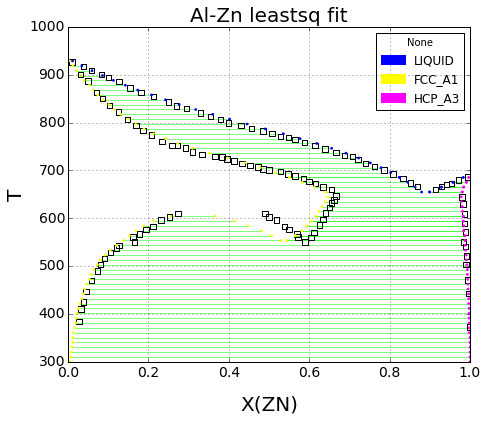

In [5]:
from pycalphad.residuals import fit_model
import numpy as np
import pandas as pd

perturbed_parameters = {
    'LIQALZN0H': 10000,
    'LIQALZN0S': 3,
    'FCCALZN0H': 7000,
    'FCCALZN0S': -0.2,
    'FCCALZN1H': 5000,
    'FCCALZN1S': 4,
    'FCCALZN2H': -3000,
    'FCCALZN2S': -3,
    'HCPALZN0H': 17000,
    'HCPALZN0S': 6,
    'HCPALZN3H': -700,
    'HCPALZN3S': 1
    }

param_names, param_values = list(zip(*perturbed_parameters.items()))
phase_eq = pd.read_csv('alzn_test_phase_eq.csv')
param_values = np.array(param_values)

%time result, mi = fit_model(perturbed_parameters, phase_eq, db_alzn, ['AL', 'ZN', 'VA'], ['LIQUID', 'HCP_A3', 'FCC_A1'])


fit_models = {
    'LIQUID': Model(db_alzn, ['AL', 'ZN'], 'LIQUID', parameters=result),
    'FCC_A1': Model(db_alzn, ['AL', 'ZN', 'VA'], 'FCC_A1', parameters=result),
    'HCP_A3': Model(db_alzn, ['AL', 'ZN', 'VA'], 'HCP_A3', parameters=result)
    }

fig = plt.figure(figsize=(9,6))
ax = binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, 'X(ZN)', 300, 1000, ax=plt.gca(), model=fit_models)
ax = phase_eq.plot(kind='scatter', x='X(ZN)', y='T', ax=ax, edgecolor='black',
                       s=30, xlim=(0,1), marker='s', facecolor='none')
ax = ax.set_title('Al-Zn leastsq fit', fontsize=20)

## Getting the fitted parameters
The **result** object contains the fitted values for the parameters.

In [7]:
import lmfit
lmfit.report_fit(mi.params)

[[Variables]]
    FCCALZN2S:  -4.05308569 +/- 37.54771 (926.40%) (init=-3)
    FCCALZN0H:   7282.83341 +/- 1.24e+04 (169.87%) (init= 7000)
    FCCALZN1H:   5525.20712 +/- 1.38e+04 (249.16%) (init= 5000)
    LIQALZN0S:   2.80094034 +/- 53.31068 (1903.31%) (init= 3)
    HCPALZN3S:   3.53758565 +/- 3.05e+03 (86078.63%) (init= 1)
    HCPALZN0S:   4.81686801 +/- 2.80e+03 (58200.67%) (init= 6)
    LIQALZN0H:   10213.0904 +/- 3.89e+04 (380.72%) (init= 10000)
    HCPALZN0H:   16196.0727 +/- 1.53e+06 (9433.03%) (init= 17000)
    FCCALZN2H:  -2497.91920 +/- 2.20e+04 (879.98%) (init=-3000)
    FCCALZN1S:   3.09055428 +/- 24.47553 (791.95%) (init= 4)
    HCPALZN3H:  -454.539117 +/- 1.65e+06 (363112.64%) (init=-700)
    FCCALZN0S:  -0.63905647 +/- 22.31785 (3492.31%) (init=-0.2)
[[Correlations]] (unreported correlations are <  0.100)
    C(HCPALZN0H, HCPALZN3H)      =  0.998 
    C(HCPALZN3S, HCPALZN0S)      =  0.998 
    C(FCCALZN0H, FCCALZN0S)      =  0.998 
    C(LIQALZN0S, LIQALZN0H)      =  0.

## Comparing with previous work

Next, we show values from Mey et al.'s 1993 assessment of the Al-Zn system. We have not done any fitting here; we are just showing how arbitrary values for the parameters may be specified and easily used to plot the phase diagram. Note the optional *parameters* keyword argument specified for each call to **Model**. This feature is what makes it easy to perform arbitrary variable substitutions in our thermodynamic models.

CPU times: user 990 ms, sys: 0 ns, total: 990 ms
Wall time: 989 ms


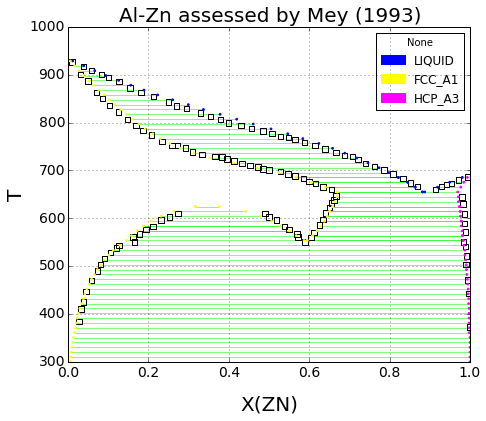

In [8]:
# Parameters from Mey (1993)
assessed_parameters = {
    'LIQALZN0H': 10465.3,
    'LIQALZN0S': 3.39259,
    'FCCALZN0H': 7297.5,
    'FCCALZN0S': -0.47512,
    'FCCALZN1H': 6612.9,
    'FCCALZN1S': 4.5911,
    'FCCALZN2H': -3097.2,
    'FCCALZN2S': -3.306635,
    'HCPALZN0H': 18821.0,
    'HCPALZN0S': 8.95255,
    'HCPALZN3H': -702.8,
    'HCPALZN3S': 0.0
    }

# Initialize phase models
assessed_models = {
    'LIQUID': Model(db_alzn, ['AL', 'ZN'], 'LIQUID', parameters=assessed_parameters),
    'FCC_A1': Model(db_alzn, ['AL', 'ZN', 'VA'], 'FCC_A1', parameters=assessed_parameters),
    'HCP_A3': Model(db_alzn, ['AL', 'ZN', 'VA'], 'HCP_A3', parameters=assessed_parameters)
    }

fig = plt.figure(figsize=(9,6))
%time ax = binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, 'X(ZN)', 300, 1000, ax=plt.gca(), model=assessed_models)
ax = phase_eq.plot(kind='scatter', x='X(ZN)', y='T', ax=ax, edgecolor='black',
                       s=30, xlim=(0,1), marker='s', facecolor='none')
ax = ax.set_title('Al-Zn assessed by Mey (1993)', fontsize=20)

## Quantitative comparison of assessment values with fitted values

The difference can be partially understood by the fact that Mey's assessment also relies on thermochemical data while here we only fit to points on the phase diagram.

In [9]:
for param_name, param_value in sorted(result.items()):
    percent_change = abs(param_value - assessed_parameters[param_name]) / abs(assessed_parameters[param_name])
    print('{0}: {1:.2%} difference'.format(param_name, percent_change))

FCCALZN0H: 0.20% difference
FCCALZN0S: 34.50% difference
FCCALZN1H: 16.45% difference
FCCALZN1S: 32.68% difference
FCCALZN2H: 19.35% difference
FCCALZN2S: 22.57% difference
HCPALZN0H: 13.95% difference
HCPALZN0S: 46.20% difference
HCPALZN3H: 35.32% difference
HCPALZN3S: inf% difference
LIQALZN0H: 2.41% difference
LIQALZN0S: 17.44% difference
